<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/2022-2/notebooks/6a_kmedias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agrupamiento mediante K-medias
En esta libreta programaremos el algoritmo de agrupamiento K-medias, el cual aplicaremos a distintos conjuntos de datos. 

In [1]:
import numpy as np
np.random.seed(2021)

import matplotlib.pyplot as plt
from sklearn import datasets

## Funciones para asignación y recálculo de centroides
El algoritmo de K-medias es un algoritmo iterativo que está compuesto de 2 pasos fundamentales:
1. Asignación de cada punto a su centroide más cercano. 
2. Recálculo de nuevos centroides a partir de las asignaciones. 

En K-medias se inicializan los centroides y posteriormente itera entre estos 2 pasos hasta que se cumple un criterio de convergencia (por ej. un número de iteraciones). De esta forma se van actualizando tanto los centroides como las asignaciones hasta converger a un agrupamiento. En particular, este algoritmo busca minimizar la siguiente función de error

$$
E[\boldsymbol{\mu}_1, \ldots, \boldsymbol{\mu}_K] = \sum_{i=1}^N \sum_{k=1}^K r_{ik} \Vert \mathbf{x}_i - \boldsymbol{\mu}_k \Vert²
$$

donde $r_{ik} = 1$ si $\boldsymbol{\mu}_k$ es el centroide más cercano a $\mathbf{x}_i$ y $r_{ik} = 0$ en caso contrario


In [2]:
class KMedias:
  def __init__(self, n_grupos, n_iter=9):
    self.n_grupos = n_grupos
    self.n_iter = n_iter

  def asigna_puntos_a_centroides(self, X):
    grupos = np.zeros(X.shape[0])
    dists = np.zeros(X.shape[0])
    for i,p in enumerate(X):
      grupos[i] = np.linalg.norm(self.centroides - p, axis = 1).argmin()
      dists[i] = np.linalg.norm(self.centroides - p, axis = 1).min()
  
    return grupos, dists

  def recalcula_centroides(self, X):
    for i in range(self.n_grupos):
      self.centroides[i,:] = X[np.where(self.grupos == i), :].mean(axis = 1)

  def fit(self, X, grafica=None):
    self.centroides = np.zeros((self.n_grupos, X.shape[1]))

    ## Inicializa centroides con puntos del conjunto elegidos aleatoriamente
    permutacion = np.random.permutation(X.shape[0])
    self.centroides[:, :] = X[permutacion[:self.n_grupos], :]

    es = np.zeros(self.n_iter + 1)
    for it in range(self.n_iter):
      self.grupos, dists = self.asigna_puntos_a_centroides(X)

      if grafica:
        grafica(X, 
                self.grupos, 
                title='Iteración ' + str(it), 
                centroides=self.centroides, 
                it=it)
      
      es[it] = np.mean(dists**2)
      self.recalcula_centroides(X)

    self.grupos, dists = self.asigna_puntos_a_centroides(X)
    es[-1] = np.mean(dists**2)

    return es

  def predict(self, X):
    return self.asigna_puntos_a_centroides(X)

## Agrupamiento del conjunto de flores iris
Como caso de estudio vamos a agrupar las flores iris por su largo y ancho del pétalo. Para este ejemplo podemos graficar los puntos y sus correspondientes asignaciones.

In [3]:
def grafica_grupos(X, grupos, title, centroides=np.array([]), grid=(4,4), it=None):
  if not plt.get_fignums():
    plt.figure(figsize=(14,14))

  if grid:
    plt.subplot(grid[0], grid[1], it + 1)

  plt.plot(X[np.where(grupos == 0), 0],
           X[np.where(grupos == 0), 1],
           'r.', markersize=10)
  plt.plot(X[np.where(grupos == 1), 0],
           X[np.where(grupos == 1), 1],
           'g.', markersize=10)
  plt.plot(X[np.where(grupos == 2), 0],
           X[np.where(grupos == 2), 1],
           'b.', markersize=10)
  
  if centroides.size != 0:
    plt.plot(centroides[0, 0], centroides[0, 1], 'ro', markersize=10)
    plt.plot(centroides[1, 0], centroides[1, 1], 'go', markersize=10)
    plt.plot(centroides[2, 0], centroides[2, 1], 'bo', markersize=10)

  plt.title(title)
  plt.xlabel('Ancho del pétalo')
  plt.ylabel('Largo del pétalo')

Primero cargamos los datos usando el módulo `datasets` de scikit-learn.

In [4]:
iris = datasets.load_iris()
datos_iris = iris['data']
datos_iris = datos_iris[:, 2:]

Corremos el algoritmo K-medias en los datos por 6 iteraciones con $K = 3$.

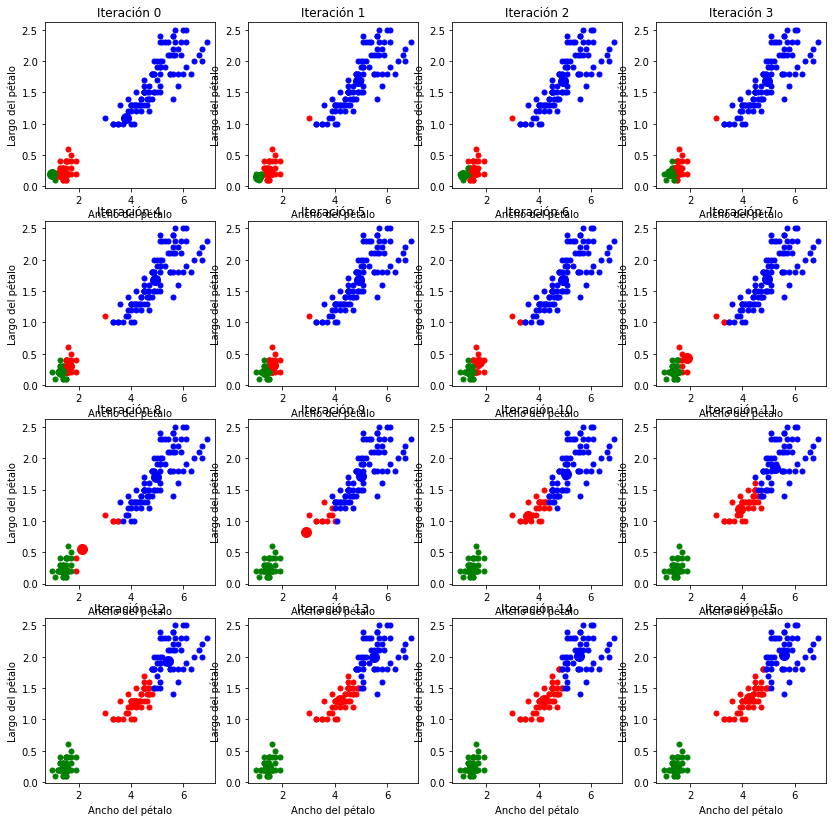

In [5]:
km_iris = KMedias(n_grupos=3, n_iter=16)
e_km_iris = km_iris.fit(datos_iris, grafica=grafica_grupos)

Graficamos el resultado del agrupamiento y lo comparamos con las etiquetas del conjunto de datos iris.

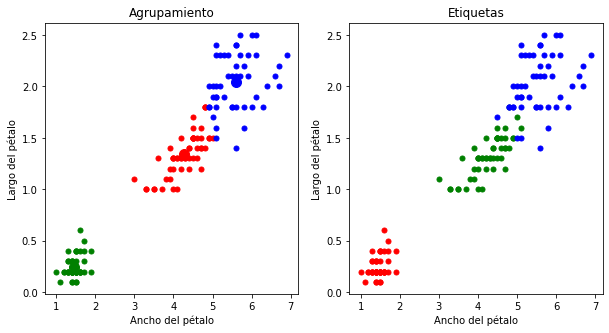

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
grafica_grupos(datos_iris, 
               km_iris.grupos, 
               'Agrupamiento', 
               centroides=km_iris.centroides,
               grid=None)
plt.subplot(1,2,2)
grafica_grupos(datos_iris, 
               iris['target'], 
               title='Etiquetas',
               grid=None)
plt.show()

Finalmente graficamos el valor de $E$ en cada iteración del algoritmo

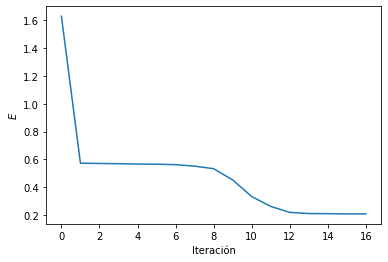

In [7]:
plt.plot(e_km_iris)
plt.xlabel('Iteración')
plt.ylabel('$E$')
plt.show()

## Caso de estudio 2: Agrupamiento de imágenes de dígitos
Nuestro segundo caso de estudio es el agrupamiento de dígitos escritos a mano. Para ello, usaremos el conjunto de datos Digits de scikit-learn, el cual tiene imágenes de $8 \times 8$ pixeles en escala de grises.

Vamos a cargar y visualizar algunas de las imágenes:

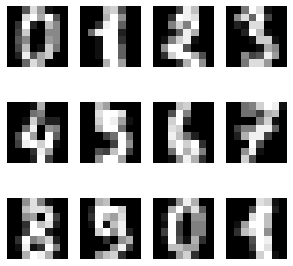

In [8]:
digits = datasets.load_digits()

plt.figure(figsize=(5,5))
for i in range(12):
  plt.subplot(3,4, i + 1)
  plt.imshow(digits.images[i], cmap='gray')
  plt.axis('off')
plt.show()

Para poder aplicar el algoritmo de K-medias debemos vectorizar las imágenes


In [9]:
X_digits = digits.images.reshape(digits.images.shape[0], 64)

Corremos el algoritmo sobre estos vectores por 10 iteraciones con $K=10$

In [10]:
km_digits = KMedias(10)
e_km_digits = km_digits.fit(X_digits, grafica=False)

Visualizamos los centroides generados por el algoritmo

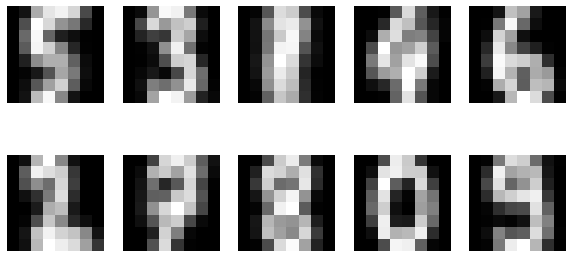

In [11]:
plt.figure(figsize=(10,5))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(km_digits.centroides[i].reshape(8,8), cmap='gray')
  plt.axis('off')
plt.show()

Visualizamos algunas imágenes asignadas a cada uno de los 10 grupos

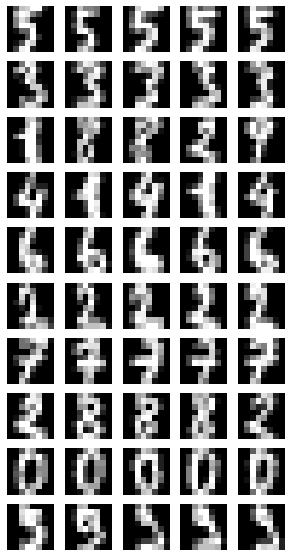

In [12]:
plt.figure(figsize=(5,10))
for i in range(10):
  m = km_digits.grupos == i
  for j in range(5):
    plt.subplot(10, 5, i * 5 + j + 1)
    plt.imshow(X_digits[m][j].reshape(8,8), cmap='gray')
    plt.axis('off')
plt.show()

Y graficamos el valor de $E$ por iteración.

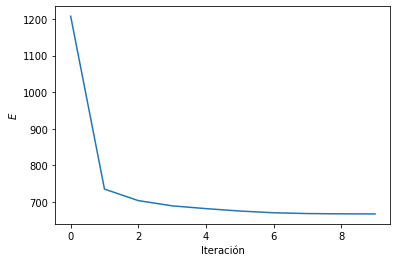

In [13]:
plt.plot(e_km_digits)
plt.xlabel('Iteración')
plt.ylabel('$E$')
plt.show()

## K-medias por mini lotes (MiniBatchKMeans)
Es una versión del algoritmo de K-medias que usa lotes pequeños de datos para actualizar los centroides y las asignaciones.

In [14]:
class KMediasMiniLotes(KMedias):
  def __init__(self, n_grupos, t_lote=10, n_iter=10):
    super().__init__(n_grupos, n_iter)
    self.t_lote = t_lote

  def fit(self, X):
    n_puntos = X.shape[0]
    permutacion = np.random.permutation(n_puntos)

    self.centroides = np.zeros((self.n_grupos, X.shape[-1]))
    self.centroides[:, :] = X[permutacion[:self.n_grupos], :]
    n_lotes = int(n_puntos / self.t_lote)

    cuentas = np.zeros(self.n_grupos)
    es = np.zeros(self.n_iter + 1)
    for it in range(self.n_iter):
      err = np.zeros(n_lotes)
      for l in range(n_lotes):
        permutacion = np.random.permutation(n_puntos)
        muestras = X[permutacion[:self.t_lote]]
        self.grupos, dists = self.asigna_puntos_a_centroides(muestras)
        err[l] = np.sum(dists**2)
        for j,x in enumerate(muestras):
          k = int(self.grupos[j])
          cuentas[k] += 1
          eta = 1.0 / cuentas[k]
          self.centroides[k] = (1.0 - eta) * self.centroides[k] + eta * x
      es[it] = err.sum() / (n_lotes * self.t_lote)

    self.grupos, dists = self.asigna_puntos_a_centroides(X)
    es[-1] = np.mean(dists**2)

    return es

Corremos el algoritmo de K-medias por mini lotes por 10 iteraciones para 3 grupos.

In [15]:
mbkm_iris = KMediasMiniLotes(n_grupos=3)
e_kml_iris = mbkm_iris.fit(datos_iris)

Visualizamos los grupos

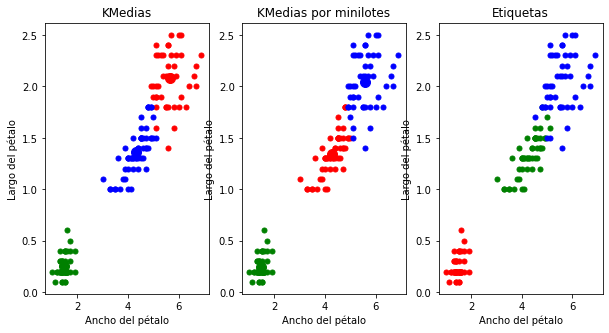

In [16]:
plt.figure(figsize=(10,5))
grafica_grupos(datos_iris, mbkm_iris.grupos, 'KMedias', centroides=mbkm_iris.centroides, grid=(1,3), it=0)
grafica_grupos(datos_iris, km_iris.grupos, 'KMedias por minilotes', centroides=km_iris.centroides, grid=(1,3), it=1)
grafica_grupos(datos_iris, iris['target'], title='Etiquetas', grid=(1,3), it=2)
plt.show()

Graficamos el error en cada iteración

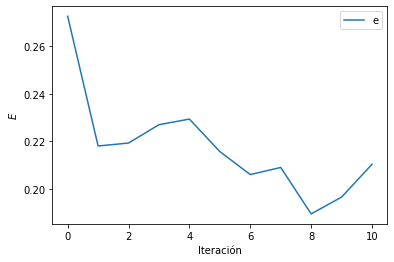

In [17]:
plt.plot(e_kml_iris, label='e')
plt.xlabel('Iteración')
plt.ylabel('$E$')
plt.legend()
plt.show()

Probamos también K-medias por minilotes en el conjunto de datos de dígitos

In [18]:
mbkm_digits = KMediasMiniLotes(10)
e_kml_digits = mbkm_digits.fit(X_digits)

Visualizamos los centroides encontrados por el algoritmo

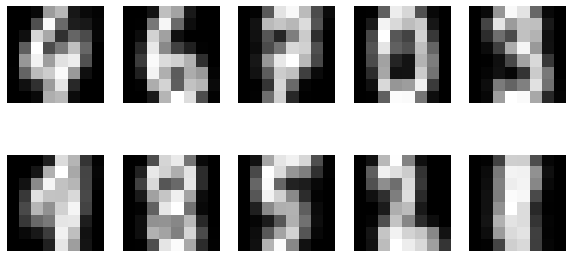

In [19]:
plt.figure(figsize=(10,5))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(mbkm_digits.centroides[i].reshape(8,8), cmap='gray')
  plt.axis('off')
plt.show()

Examinamos algunos ejemplos asignados a cada grupo

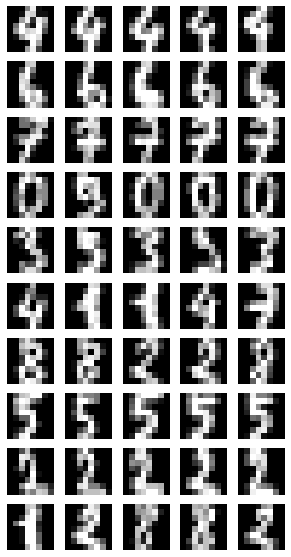

In [20]:
plt.figure(figsize=(5,10))
for i in range(10):
  m = mbkm_digits.grupos == i
  for j in range(5):
    plt.subplot(10, 5, i * 5 + j + 1)
    plt.imshow(X_digits[m][j].reshape(8,8), cmap='gray')
    plt.axis('off')
plt.show()

Graficamos el error en cada iteración

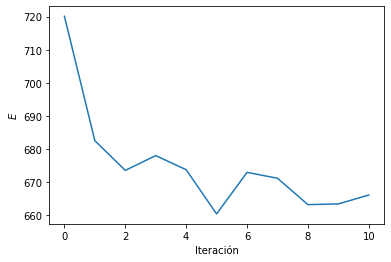

In [21]:
plt.plot(e_kml_digits)
plt.xlabel('Iteración')
plt.ylabel('$E$')
plt.show()